<a href="https://colab.research.google.com/github/soobook/PyTorch-DL/blob/main/code/PT13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 13회차: RNN을 활용한 영화평 감성 분석 (3) - 모델 학습 및 평가

## RNN 구현: IMDB 영화평 감성 분석




- 12회차 RNN 구현 초반

In [1]:
# 1. 라이브러리 불러오기
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

# 2. 환경 설정: GPU 사용 가능 시 GPU 사용
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Running on: {device}")

# 3. 데이터 로딩 및 전처리
vocab_size = 10000  # 상위 10,000개의 단어만 사용
max_len = 500       # 모든 리뷰를 길이 500으로 패딩 또는 자름

# IMDB 데이터셋 로딩 (이미 토큰화 되어 있음)
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size)

# 리뷰 길이 맞추기 (길이 부족한 건 0으로 채움)
x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)

Running on: cuda
17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [2]:
# 텐서로 변환
x_train_tensor = torch.tensor(x_train, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# 변환된 텐서 출력
print("x_train_tensor:", x_train_tensor)
print("y_train_tensor:", y_train_tensor)
print("x_test_tensor:", x_test_tensor)
print("y_test_tensor:", y_test_tensor)

x_train_tensor: tensor([[   0,    0,    0,  ...,   19,  178,   32],
        [   0,    0,    0,  ...,   16,  145,   95],
        [   0,    0,    0,  ...,    7,  129,  113],
        ...,
        [   0,    0,    0,  ...,    4, 3586,    2],
        [   0,    0,    0,  ...,   12,    9,   23],
        [   0,    0,    0,  ...,  204,  131,    9]])
y_train_tensor: tensor([1., 0., 0.,  ..., 0., 1., 0.])
x_test_tensor: tensor([[   0,    0,    0,  ...,   14,    6,  717],
        [   0,    0,    0,  ...,  125,    4, 3077],
        [  33,    6,   58,  ...,    9,   57,  975],
        ...,
        [   0,    0,    0,  ...,   21,  846, 5518],
        [   0,    0,    0,  ..., 2302,    7,  470],
        [   0,    0,    0,  ...,   34, 2005, 2643]])
y_test_tensor: tensor([0., 1., 1.,  ..., 0., 0., 0.])


In [3]:
# 4. Dataset 및 DataLoader 구성
BATCH_SIZE = 64
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# 첫 번째 배치 확인
for x_batch, y_batch in train_loader:
    print("x_batch shape:", x_batch.shape)
    print("y_batch shape:", y_batch.shape)
    print("x_batch sample:", x_batch[0])
    print("y_batch sample:", y_batch[0])
    break  # 첫 번째 배치만 확인

x_batch shape: torch.Size([64, 500])
y_batch shape: torch.Size([64])
x_batch sample: tensor([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    

### nn.Embedding()을 이해하기 위한 간단 코드

In [ ]:
# nn.Embedding()을 이해하기 위한 간단 코드
import torch
import torch.nn as nn

# 1. 임베딩 레이어 정의 (vocab_size=10, embed_dim=4)
embedding = nn.Embedding(num_embeddings=10, embedding_dim=4)

# 2. 입력 시퀀스 정의 (정수 인덱스)
input_indices = torch.tensor([1, 3, 5, 7])  # 예: 문장의 단어 인덱스

# 3. 임베딩 적용
embedded_vectors = embedding(input_indices)

# 4. 결과 출력
print("입력 인덱스:", input_indices)
print("임베딩 벡터:\n", embedded_vectors)
print("출력 shape:", embedded_vectors.shape)
# embedding.weight는 내부적으로 (10, 4) 크기의 테이블
print("weight matrix 전체 보기:\n", embedding.weight)

입력 인덱스: tensor([1, 3, 5, 7])
임베딩 벡터:
 tensor([[-0.8091,  0.5643,  0.3736,  1.6919],
        [ 0.5205, -1.3695,  0.7880,  0.5363],
        [ 1.2066, -0.2790, -0.9787, -0.1047],
        [ 0.0381,  3.2131, -0.0651,  2.4298]], grad_fn=<EmbeddingBackward0>)
출력 shape: torch.Size([4, 4])
weight matrix 전체 보기:
 Parameter containing:
tensor([[ 1.1807, -0.5281, -1.2340, -0.1198],
        [-0.8091,  0.5643,  0.3736,  1.6919],
        [ 0.2701, -0.7882,  0.6264,  0.8540],
        [ 0.5205, -1.3695,  0.7880,  0.5363],
        [-1.6016, -0.3977, -1.2734,  0.6794],
        [ 1.2066, -0.2790, -0.9787, -0.1047],
        [-0.2621, -0.8054,  0.5444, -0.5841],
        [ 0.0381,  3.2131, -0.0651,  2.4298],
        [ 0.4251,  0.5489,  0.6270, -0.0237],
        [ 0.7140,  0.7868,  1.0263, -1.0034]], requires_grad=True)


In [ ]:
import torch
import torch.nn as nn

# 1. 임베딩 레이어 정의 (vocab_size=10, embed_dim=4)
embedding = nn.Embedding(num_embeddings=10, embedding_dim=4)

# 2. 입력 시퀀스 정의 (정수 인덱스)
input_indices = torch.tensor([1, 3, 5, 7])  # 예: 문장의 단어 인덱스 (배치 X, 시퀀스만)

# 3. 임베딩 적용 → 인덱스에 해당하는 벡터들을 weight matrix에서 추출
embedded_vectors = embedding(input_indices)

# 4. 출력 결과 확인
print("입력 인덱스:", input_indices.tolist())
print("임베딩 벡터:\n", embedded_vectors)
print("출력 shape:", embedded_vectors.shape)  # [4, 4]

# 5. 임베딩 테이블 전체 보기 → 학습 가능한 weight matrix
print("\n[전체 임베딩 weight matrix] (크기: [10, 4])")
print(embedding.weight)

# 6. 각 인덱스에 대응하는 벡터 직접 확인
print("\n[embedding.weight[n] 직접 확인]")
for idx in input_indices:
    print(f"embedding.weight[{idx.item()}] = {embedding.weight[idx].tolist()}")


입력 인덱스: [1, 3, 5, 7]
임베딩 벡터:
 tensor([[ 0.1155,  0.3460, -0.2215, -1.7931],
        [-0.3175, -1.7439,  1.6973,  1.9057],
        [-0.0920, -0.4998, -0.2309, -1.7100],
        [ 2.4779,  0.7979, -0.8960, -0.0795]], grad_fn=<EmbeddingBackward0>)
출력 shape: torch.Size([4, 4])

[전체 임베딩 weight matrix] (크기: [10, 4])
Parameter containing:
tensor([[-0.2393,  0.4646, -0.3195, -1.2801],
        [ 0.1155,  0.3460, -0.2215, -1.7931],
        [ 0.5351, -0.4447,  0.5888, -0.1713],
        [-0.3175, -1.7439,  1.6973,  1.9057],
        [-0.3114, -0.0817,  1.2077, -0.0178],
        [-0.0920, -0.4998, -0.2309, -1.7100],
        [-0.7376,  0.1127,  0.7617,  1.2652],
        [ 2.4779,  0.7979, -0.8960, -0.0795],
        [ 1.3986, -0.5461, -1.4532, -0.2581],
        [-0.7420, -0.9270,  0.2436, -0.9622]], requires_grad=True)

[embedding.weight[n] 직접 확인]
embedding.weight[1] = [0.11553189158439636, 0.3460375964641571, -0.22151224315166473, -1.7931437492370605]
embedding.weight[3] = [-0.3175424337387085, -1.74

### 다시 모델 클래스 정의

In [ ]:
class LSTMModel(nn.Module):
    # 모델 초기화: 어휘 수, 임베딩 차원 수, LSTM 은닉 상태 차원 수를 받아서 구성함
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super().__init__()
        # 입력 정수 인덱스를 임베딩 벡터로 변환하는 계층 (word embedding)
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        # LSTM 계층: 시퀀스 데이터를 처리하고 시점 간의 문맥 정보를 학습
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        # 출력층: LSTM의 마지막 hidden state를 이진 분류를 위한 단일 출력값으로 변환
        self.fc = nn.Linear(hidden_dim, 1)
        # 시그모이드 함수: 출력값을 0~1 사이의 확률로 변환
        self.sigmoid = nn.Sigmoid()

    # 순전파 정의: 입력 시퀀스를 받아 예측 확률을 출력
    def forward(self, x):
        # 정수 인덱스 시퀀스를 임베딩 벡터 시퀀스로 변환 (형태: [batch, seq_len] → [batch, seq_len, embed_dim])
        x = self.embedding(x)
        # LSTM에 임베딩된 시퀀스를 전달하고, 마지막 시점의 hidden state만 추출
        _, (hidden, _) = self.lstm(x)
        # 마지막 레이어의 hidden state(hidden[-1])를 선형 변환하여 이진 분류 로짓 계산
        out = self.fc(hidden[-1])
        # 시그모이드 함수를 통해 0~1 사이의 확률값 출력, squeeze로 [batch, 1] → [batch]로 차원 축소
        return self.sigmoid(out).squeeze()

In [5]:
# 5. LSTM 기반 이진 분류 모델 정의
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)  # 단어 임베딩
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)  # LSTM
        self.fc = nn.Linear(hidden_dim, 1)  # 출력층 (이진 분류)
        self.sigmoid = nn.Sigmoid()  # 확률화

    def forward(self, x):
        x = self.embedding(x)                   # [batch, seq_len] → [batch, seq_len, embed_dim]
        _, (hidden, _) = self.lstm(x)           # hidden: [1, batch, hidden_dim]
        out = self.fc(hidden[-1])               # hidden[-1]: 마지막 layer의 hidden state
        return self.sigmoid(out).squeeze()      # 결과를 확률로 변환

In [6]:
# 모델, 손실 함수, 옵티마이저 정의
model = LSTMModel(vocab_size, embed_dim=128, hidden_dim=64).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
# 6. 모델 학습 루프
num_epochs = 20
train_losses = []

print("Training started...")
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

Training started...
Epoch 1/20, Loss: 0.5856
Epoch 2/20, Loss: 0.4074
Epoch 3/20, Loss: 0.3855
Epoch 4/20, Loss: 0.2873
Epoch 5/20, Loss: 0.2423
Epoch 6/20, Loss: 0.2427
Epoch 7/20, Loss: 0.2014
Epoch 8/20, Loss: 0.1559
Epoch 9/20, Loss: 0.1363
Epoch 10/20, Loss: 0.1041
Epoch 11/20, Loss: 0.0862
Epoch 12/20, Loss: 0.0799
Epoch 13/20, Loss: 0.0740
Epoch 14/20, Loss: 0.0540
Epoch 15/20, Loss: 0.0409
Epoch 16/20, Loss: 0.0538
Epoch 17/20, Loss: 0.0432
Epoch 18/20, Loss: 0.0495
Epoch 19/20, Loss: 0.0209
Epoch 20/20, Loss: 0.0102


In [8]:
%config InlineBackend.figure_format = 'retina'

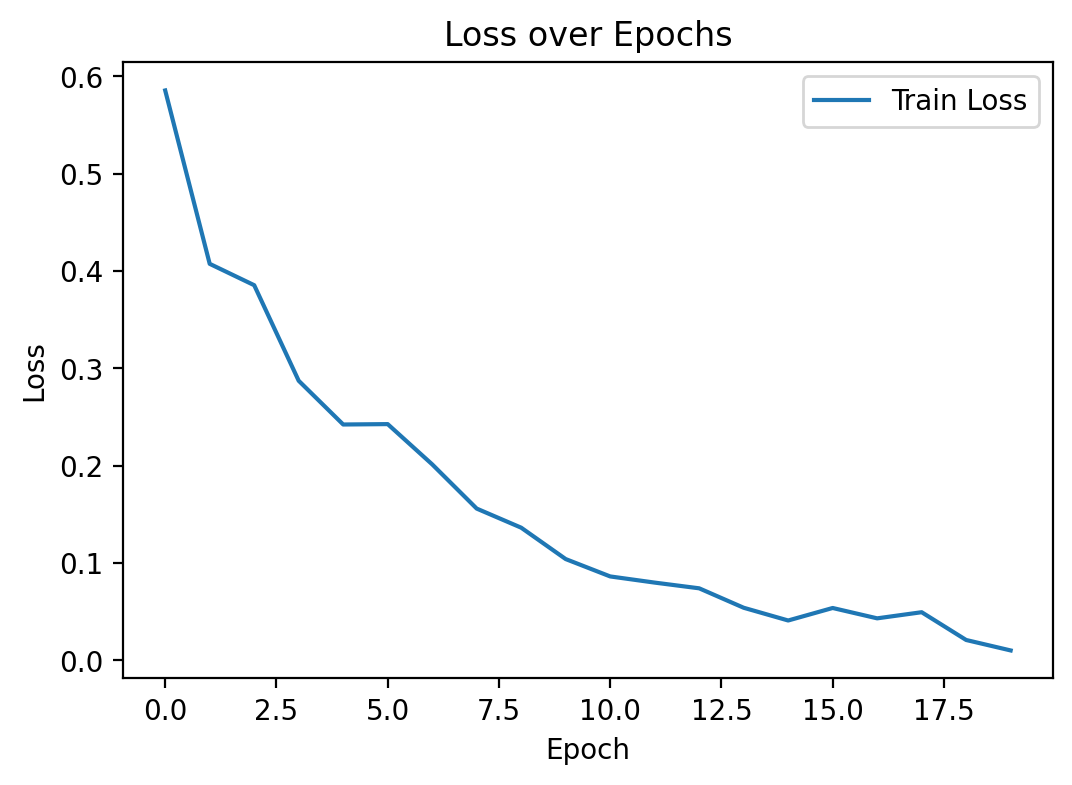

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))

# 7. 손실 시각화
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

In [10]:
# 8. 정확도 평가 함수
def evaluate(model, dataloader):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predictions = (outputs > 0.5).float()
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    return correct / total

# 9. 테스트 정확도 출력
accuracy = evaluate(model, test_loader)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 85.23%


### 심화 학습

In [ ]:
# 10. 잘못 예측한 샘플 중 부정(0)을 긍정으로, 긍정(1)을 부정으로 예측한 사례 출력
print("\n오분류 예시:")

model.eval()
false_positive_found = False
false_negative_found = False

with torch.no_grad():
    for i in range(len(x_test_tensor)):
        input_seq = x_test_tensor[i].unsqueeze(0).to(device)
        label = y_test_tensor[i].item()
        output = model(input_seq)
        prediction = 1.0 if output.item() > 0.5 else 0.0

        # 부정(0)을 긍정(1)으로 예측한 경우
        if label == 0.0 and prediction == 1.0 and not false_positive_found:
            print(f"\nFalse Positive (부정을 긍정으로 예측)\n실제 레이블: {int(label)}, 예측: {int(prediction)}")
            print(f"리뷰 토큰: {x_test_tensor[i].tolist()}")
            false_positive_found = True

        # 긍정(1)을 부정(0)으로 예측한 경우
        if label == 1.0 and prediction == 0.0 and not false_negative_found:
            print(f"\nFalse Negative (긍정을 부정으로 예측)\n실제 레이블: {int(label)}, 예측: {int(prediction)}")
            print(f"리뷰 토큰: {x_test_tensor[i].tolist()}")
            false_negative_found = True

        if false_positive_found and false_negative_found:
            break


오분류 예시:

False Positive (부정을 긍정으로 예측)
실제 레이블: 0, 예측: 1
리뷰 토큰: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

## IMDA 데이터셋을 활용한 LSTM 모델 구현 전체 코드

✅ Running on: cuda
🚀 Training started...
Epoch 1/20, Loss: 0.5809
Epoch 2/20, Loss: 0.5057
Epoch 3/20, Loss: 0.3771
Epoch 4/20, Loss: 0.3512
Epoch 5/20, Loss: 0.2632
Epoch 6/20, Loss: 0.2530
Epoch 7/20, Loss: 0.1802
Epoch 8/20, Loss: 0.1466
Epoch 9/20, Loss: 0.1144
Epoch 10/20, Loss: 0.1172
Epoch 11/20, Loss: 0.0687
Epoch 12/20, Loss: 0.0498
Epoch 13/20, Loss: 0.0367
Epoch 14/20, Loss: 0.0415
Epoch 15/20, Loss: 0.0175
Epoch 16/20, Loss: 0.0150
Epoch 17/20, Loss: 0.0120
Epoch 18/20, Loss: 0.0312
Epoch 19/20, Loss: 0.0203
Epoch 20/20, Loss: 0.0203


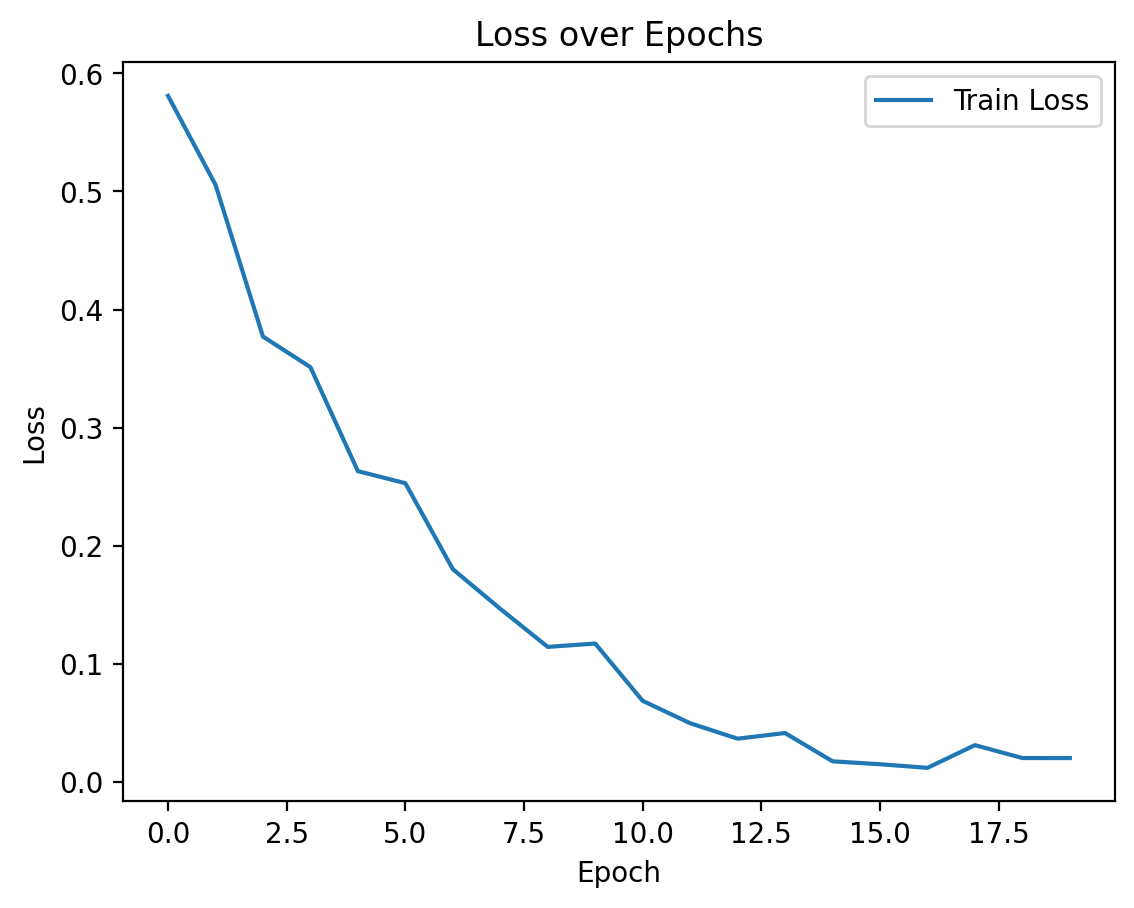

Test Accuracy: 86.50%


In [ ]:
# 1. 라이브러리 불러오기
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

# 2. 환경 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Running on: {device}")

# 3. 데이터 로딩 및 전처리
vocab_size = 10000  # 가장 자주 등장한 10,000개의 단어만 사용
max_len = 500       # 문장 길이 고정

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size)

x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)

x_train_tensor = torch.tensor(x_train, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# 4. Dataset 및 DataLoader
BATCH_SIZE = 64
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# 5. LSTM 모델 정의
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        _, (hidden, _) = self.lstm(x)
        return self.sigmoid(self.fc(hidden[-1])).squeeze()

model = LSTMModel(vocab_size, embed_dim=128, hidden_dim=128).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 6. 모델 학습
num_epochs = 20
train_losses = []

print("🚀 Training started...")
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

# 7. 손실 시각화
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

# 8. 정확도 평가 함수
def evaluate(model, dataloader):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predictions = (outputs > 0.5).float()
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    return correct / total

# 9. 테스트 정확도 출력
accuracy = evaluate(model, test_loader)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


## 종료